In [1]:
# From https://neuraloperator.github.io/neuraloperator/dev/auto_examples/plot_FNO_darcy.html
from ml_model import model
from neuralop.datasets import load_darcy_flow_small
import torch

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import ticker

In [2]:
def G_operator(x):
    """Takes a permeability field and returns the pressure field.

    Args:
        x: Permeability field.

    Returns:
        y: Pressure field.
    """    
    return model(x.unsqueeze(0))

Loading test db at resolution 32 with 50 samples and batch-size=32


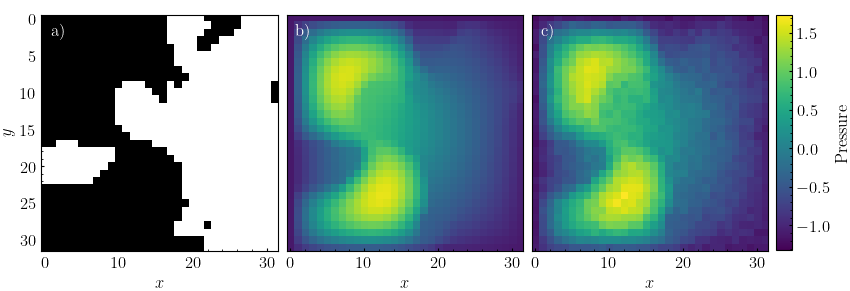

In [3]:
train_loader, test_loaders, data_processor = load_darcy_flow_small(
    n_train=1000, batch_size=32,
    test_resolutions=[16, 32], n_tests=[100, 50],
    test_batch_sizes=[32, 32],
    positional_encoding=True
)
test_samples = test_loaders[32].dataset

STD_DEV = 0.05  # Standard deviation of the Gaussian noise, mean is 0
dataset = test_samples[0]
dataset = data_processor.preprocess(dataset, batched=False)
ref_permeability = dataset['x']
ref_pressure_true = dataset['y']
ref_pressure_true_noisy = ref_pressure_true + STD_DEV * torch.randn_like(ref_pressure_true)
ref_pressure_ML = G_operator(ref_permeability)

min_pressure = min(ref_pressure_true.min(), ref_pressure_true_noisy.min())
max_pressure = max(ref_pressure_true.max(), ref_pressure_true_noisy.max())

fig = plt.figure(layout="constrained", figsize=(8, 3))
gs = GridSpec(1, 4, figure=fig, width_ratios=[1, 1, 1, .065], height_ratios=[1], wspace=0.00, hspace=0.00)

# Plot reference permeability
ax = fig.add_subplot(gs[0, 0])
ax.imshow(ref_permeability[0], cmap='gray')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.text(0.07, 0.93, 'a)', transform=ax.transAxes, ha='center', va='center', zorder=100, color='white')

# Plot reference pressure
ax = fig.add_subplot(gs[0, 1])
ax.imshow(ref_pressure_true.squeeze().detach().numpy(), vmin=min_pressure, vmax=max_pressure)
plt.xlabel(r'$x$')
plt.yticks([], [])
plt.text(0.07, 0.93, 'b)', transform=ax.transAxes, ha='center', va='center', zorder=100, color='white')

# Plot reference noisy pressure
ax = fig.add_subplot(gs[0, 2])
ax.imshow(ref_pressure_true_noisy.squeeze().detach().numpy(), vmin=min_pressure, vmax=max_pressure)
plt.xlabel(r'$x$')
plt.yticks([], [])
plt.text(0.07, 0.93, 'c)', transform=ax.transAxes, ha='center', va='center', zorder=100, color='white')

# Colorbar in last column
ax_big = fig.add_subplot(gs[0, 3])
ax_big.axis('off')
norm = mpl.colors.Normalize(vmin=min_pressure, vmax=max_pressure)
ax = inset_axes(ax_big, width="100%", height="88%", loc=10)  # 10 = center
cbar = mpl.colorbar.ColorbarBase(ax, cmap='viridis', orientation='vertical', norm=norm)
cbar.set_label('Pressure')

plt.savefig('permeability_pressure.png', dpi=300, bbox_inches='tight')